In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [10]:
# load data
df = pd.read_csv('togo-dapaong_qc.csv')
df.head() # show top 5 rows
# df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


In [11]:
df.describe(include='number')

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
std,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN
min,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN


In [ ]:
# 1. Summary Statistics & Missing-Value Report
missing = df.isna().sum().to_frame(name='Missing Values')
missing

,Missing Values
Timestamp,0
GHI,0
DNI,0
DHI,0
ModA,0
ModB,0
Tamb,0
RH,0
WS,0
WSgust,0


In [21]:
missing['Missing %'] = (missing['Missing Values'] / len(df)) * 100
high_missing = missing[missing['Missing %'] > 5]
high_missing

,Missing Values,Missing %
Comments,525600,100.0


In [22]:
# since Comments have missing value of > 100% drop it
df=df.drop(columns=['Comments'])

# GHI (Global Horizontal Irradiance) measures sunlight energy reaching Earth’s surface (W/m²).
# By definition, GHI cannot be negative because sunlight intensity ranges from 0 (night) to ~1000+ W/m² (peak daylight).
df['GHI'] = df['GHI'].clip(lower=0)  # Clip negative GHI to 0

In [26]:
# 2. Outlier Detection & Basic Cleaning
# Calculate Z-scores for key columns
cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[cols].apply(stats.zscore)
outliers = (np.abs(z_scores) > 3).any(axis=1)
print(f"Rows with outliers: {outliers.sum()}")

Rows with outliers: 9257


In [31]:
for col in cols:
    median = df[col].median()
    df[col] = np.where(np.abs(z_scores[col]) > 3, median, df[col])
os.makedirs('data', exist_ok=True)
df.to_csv('data/togo_clean.csv', index=False)

/home/leul/anaconda3/envs/ml_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


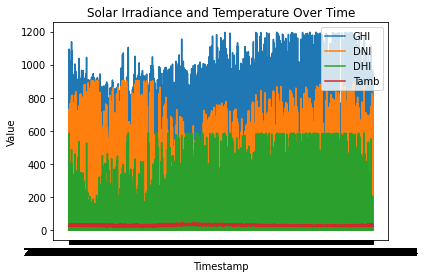

In [32]:
# 3. Time series analysis
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df['Timestamp'], df[col], label=col)
plt.title('Solar Irradiance and Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()